In [1]:
import pandas as pd
import numpy as np
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

/Users/hannicho19/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from matplotlib.pyplot import *
from IPython.display import display, HTML
import glob
from anndata import AnnData

In [3]:
cd /Users/hannicho19/Desktop

/Users/hannicho19/Desktop


In [ ]:
# This is an example of QC pre-processing for the single cell data 

In [4]:
# read in the file
file = "/Users/hannicho19/Desktop/D30.h5"
adata = sc.read(file)

In [5]:
# show the dimension
adata.n_obs

250923

In [5]:
# show the top of the file 
adata.obs.head()

,sample_index,sample_id,donor_id,cluster_id,celltype,time_point,pool_id,treatment
index,,,,,,,,
AAACCTGAGAGCTATA-1-0,0,5245STDY7387187,HPSI0714i-iudw_1,0,DA,D30,pool1,NONE
AAACCTGAGCTAGTCT-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,3,Epen1,D30,pool1,NONE
AAACCTGAGTGTTAGA-1-0,0,5245STDY7387187,HPSI0614i-liqa_1,2,Sert,D30,pool1,NONE
AAACCTGCAACCGCCA-1-0,0,5245STDY7387187,HPSI0115i-paim_1,1,FPP,D30,pool1,NONE
AAACCTGCAAGGGTCA-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,1,FPP,D30,pool1,NONE


In [8]:
han = adata.var
han.to_csv("var.csv")

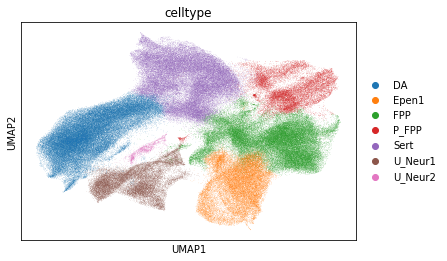

In [6]:
# Clustering and annotation step has been already done. The umap plot looks is plotted here. 
plotting_fcn = sc.pl.umap
plotting_fcn(adata, color='celltype')

In [7]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['DA']
adata_DA = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_DA.obs.head()

,sample_index,sample_id,donor_id,cluster_id,celltype,time_point,pool_id,treatment
index,,,,,,,,
AAACCTGAGAGCTATA-1-0,0,5245STDY7387187,HPSI0714i-iudw_1,0,DA,D30,pool1,NONE
AAACCTGCAATTGCTG-1-0,0,5245STDY7387187,HPSI0115i-paim_1,0,DA,D30,pool1,NONE
AAACCTGCAGAGCCAA-1-0,0,5245STDY7387187,HPSI0614i-liqa_1,0,DA,D30,pool1,NONE
AAACCTGCATCCCACT-1-0,0,5245STDY7387187,HPSI0115i-paim_1,0,DA,D30,pool1,NONE
AAACCTGCATGCCACG-1-0,0,5245STDY7387187,HPSI0914i-suop_5,0,DA,D30,pool1,NONE


In [8]:
# step1.calclate qc metrics 
adata_DA.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_DA, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


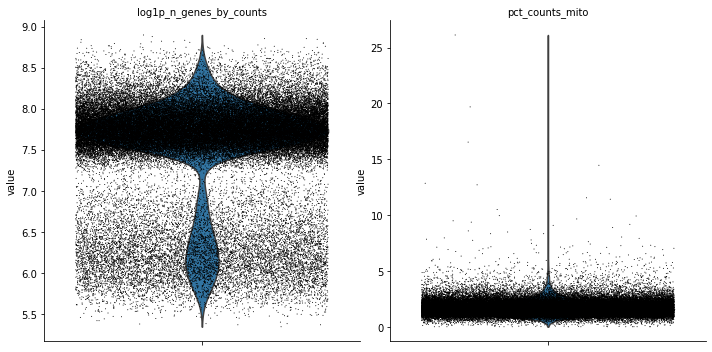

In [9]:
# step2. plotting the qc metrics
sc.pl.violin(adata_DA, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

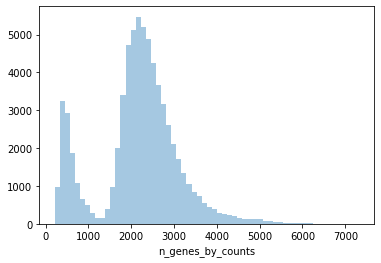

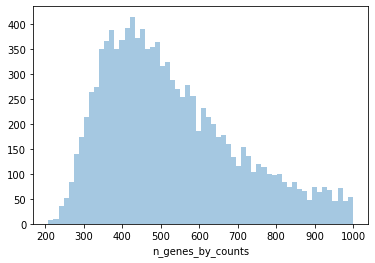

In [10]:
#step 3.we come up with thresholding decsions for genes for the DA cells

p6 = sb.distplot(adata_DA.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

# there seems to be a small population of cells expressing low (1000 gene) count, let's zoom in

p7 = sb.distplot(adata_DA.obs['n_genes_by_counts'][adata_DA.obs['n_genes_by_counts']<1000], kde=False, bins=60)
plt.show()

In [11]:
# QC 1 - cell level - remove cells with low gene counts 
# Here, we filter out the cells with low gene counts, threshold set around 1000 - 
# let's filter out 

# for the DA cells 
print('Number of cells before gene filter: {:d}'.format(adata_DA.n_obs))
sc.pp.filter_cells(adata_DA, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata_DA.n_obs))




Number of cells before gene filter: 69007
Number of cells after gene filter: 57892


In [12]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_DA.n_obs))
adata_DA = adata_DA[adata_DA.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_DA.n_obs))


Number of cells before MT filter: 57892
Number of cells after MT filter: 57718


In [13]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the DA cells
print('Total number of genes: {:d}'.format(adata_DA.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_DA, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_DA.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 19497


In [15]:
adata_DA.var

,gene_ids-0,gene_ids-1,gene_ids-2,gene_ids-3,gene_ids-4,gene_ids-5,gene_ids-6,gene_ids-7,gene_ids-8,gene_ids-9,...,gene_ids-32,gene_ids-33,mito,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
index,,,,,,,,,,,,,,,,,,,,,
MIR1302-10,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,...,ENSG00000243485,ENSG00000243485,False,27,0.000984,0.000983,99.960874,67.873528,4.232272,23
RP11-34P13.7,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,...,ENSG00000238009,ENSG00000238009,False,117,0.002395,0.002392,99.830452,165.283524,5.113694,113
AL627309.1,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,...,ENSG00000237683,ENSG00000237683,False,348,0.007257,0.007231,99.495703,500.771576,6.218145,336
AP006222.2,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,...,ENSG00000228463,ENSG00000228463,False,14834,0.365298,0.311373,78.503630,25208.125000,10.134961,14243
RP4-669L17.10,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,...,ENSG00000237094,ENSG00000237094,False,233,0.006007,0.005989,99.662353,414.491608,6.029462,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,...,ENSG00000220023,ENSG00000220023,False,12263,0.343387,0.295194,82.229339,23696.136719,10.073110,11762
AC011841.1,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,...,ENSG00000212884,ENSG00000212884,False,322,0.005537,0.005522,99.533381,382.082855,5.948251,319
AL354822.1,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,...,ENSG00000215615,ENSG00000215615,False,24,0.000387,0.000387,99.965221,26.726358,3.322384,24


In [14]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_DA_cpm = adata_DA.copy() # apply this to a copy so we can compare methods
adata_DA_cpm.raw = adata_DA_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_DA_cpm, 
                         counts_per_cell_after=1e6)


In [15]:
# log transformation 
sc.pp.log1p(adata_DA_cpm)
adata_DA_cpm

AnnData object with n_obs × n_vars = 57718 × 19497
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_genes', 'n_counts'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-14', 'gene_ids-15', 'gene_ids-16', 'gene_ids-17', 'gene_ids-18', 'gene_ids-19', 'gene_ids-20', 'gene_ids-21', 'gene_ids-22', 'gene_ids-23', 'gene_ids-24', 'gene_ids-25', 'gene_ids-26', 'gene_ids-27', 'gene_ids-28', 'gene_ids-29', 'gene_ids-30', 'gene_ids-31', 'gene_ids-32', 'gene_ids-33', 'mito', 'n_cells_by_counts',

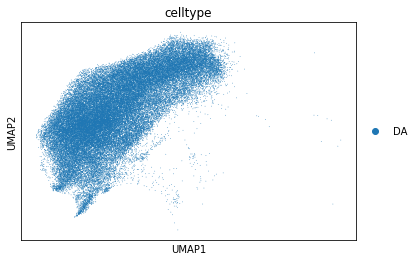

In [45]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_DA_cpm, color='celltype')

In [16]:
# aggregate the normalized and log-transformed data for per gene per individual
# we use mean aggreagation

means = pd.DataFrame(index=adata_DA_cpm.var_names)
for k, indices in adata_DA.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_DA_cpm.X[indices].mean(axis=0))

df = means

In [18]:
# write dataframe to csv 
df.to_csv("DA.csv")



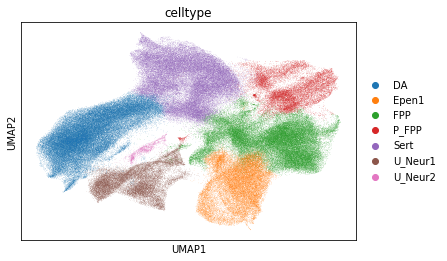

In [49]:
# now let's do the same for the other cell type - Epen1
# since this data has been already clustered and annotated- let's plot the umap plot 
plotting_fcn = sc.pl.umap
plotting_fcn(adata, color='celltype')

In [19]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['Epen1']
adata_Epen = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Epen.obs.head()

,sample_index,sample_id,donor_id,cluster_id,celltype,time_point,pool_id,treatment
index,,,,,,,,
AAACCTGAGCTAGTCT-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,3,Epen1,D30,pool1,NONE
AAACCTGCAGACACTT-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,3,Epen1,D30,pool1,NONE
AAACCTGTCAGTTCGA-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,3,Epen1,D30,pool1,NONE
AAACCTGTCGATCCCT-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,3,Epen1,D30,pool1,NONE
AAACGGGCACAACGCC-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,3,Epen1,D30,pool1,NONE


In [20]:
# step1.calclate qc metrics 
adata_Epen.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Epen, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


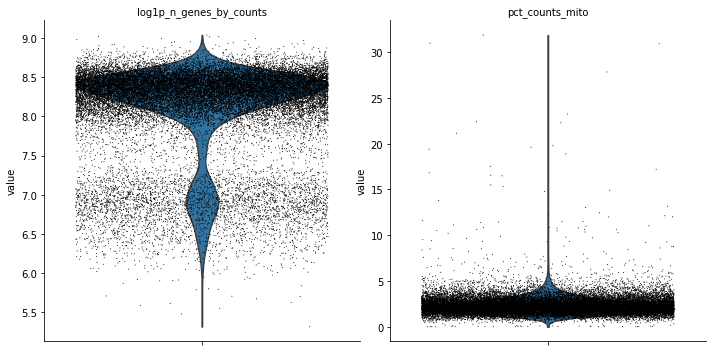

In [21]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Epen, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

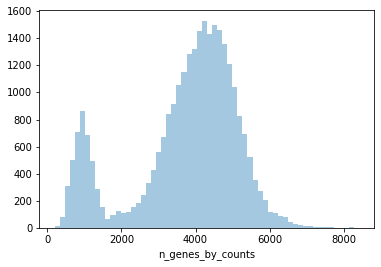

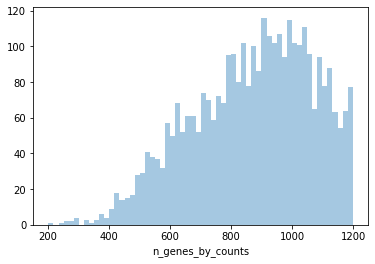

In [22]:
#step 3.we come up with thresholding decsions for genes for the Epen1 cells

p6 = sb.distplot(adata_Epen.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

# there seems to be a small population of cells expressing low (1000 gene) count, let's zoom in

p7 = sb.distplot(adata_Epen.obs['n_genes_by_counts'][adata_Epen.obs['n_genes_by_counts']<1200], kde=False, bins=60)
plt.show()

In [23]:
# QC 1 - cell level - remove cells with low gene counts 
# Here, we filter out the cells with low gene counts, threshold set around 1000 - 
# let's filter out 

 
print('Number of cells before gene filter: {:d}'.format(adata_Epen.n_obs))
sc.pp.filter_cells(adata_Epen, min_genes = 1200)
print('Number of cells after gene filter: {:d}'.format(adata_Epen.n_obs))



Number of cells before gene filter: 28145
Number of cells after gene filter: 24826


In [24]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Epen.n_obs))
adata_Epen = adata_Epen[adata_Epen.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Epen.n_obs))


Number of cells before MT filter: 24826
Number of cells after MT filter: 24556


In [25]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the Epen cells
print('Total number of genes: {:d}'.format(adata_Epen.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Epen, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Epen.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 20417


In [26]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Epen_cpm = adata_Epen.copy() # apply this to a copy so we can compare methods
adata_Epen_cpm.raw = adata_Epen_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Epen_cpm, 
                         counts_per_cell_after=1e6)

In [27]:
# log transformation 
sc.pp.log1p(adata_Epen_cpm)
adata_Epen_cpm

AnnData object with n_obs × n_vars = 24556 × 20417
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_genes', 'n_counts'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-14', 'gene_ids-15', 'gene_ids-16', 'gene_ids-17', 'gene_ids-18', 'gene_ids-19', 'gene_ids-20', 'gene_ids-21', 'gene_ids-22', 'gene_ids-23', 'gene_ids-24', 'gene_ids-25', 'gene_ids-26', 'gene_ids-27', 'gene_ids-28', 'gene_ids-29', 'gene_ids-30', 'gene_ids-31', 'gene_ids-32', 'gene_ids-33', 'mito', 'n_cells_by_counts',

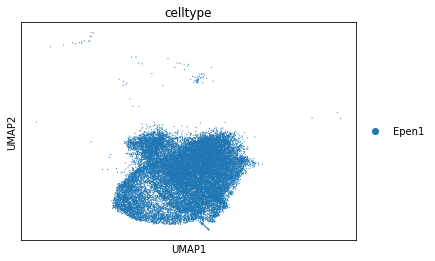

In [14]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Epen_cpm, color='celltype')

In [28]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Epen_cpm.var_names)
for k, indices in adata_Epen.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Epen_cpm.X[indices].mean(axis=0))
df = means

In [30]:
df.to_csv("Epen1.csv")

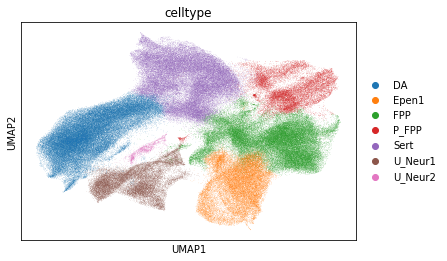

In [20]:
# now let's do the same for the other cell type - FPP
# since this data has been already clustered and annotated- let's plot the umap plot 
plotting_fcn = sc.pl.umap
plotting_fcn(adata, color='celltype')

In [31]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['FPP']
adata_FPP = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_FPP.obs.head()

,sample_index,sample_id,donor_id,cluster_id,celltype,time_point,pool_id,treatment
index,,,,,,,,
AAACCTGCAACCGCCA-1-0,0,5245STDY7387187,HPSI0115i-paim_1,1,FPP,D30,pool1,NONE
AAACCTGCAAGGGTCA-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,1,FPP,D30,pool1,NONE
AAACCTGCAATCCGAT-1-0,0,5245STDY7387187,HPSI0115i-paim_1,1,FPP,D30,pool1,NONE
AAACCTGCAGCGAACA-1-0,0,5245STDY7387187,HPSI0115i-paim_1,1,FPP,D30,pool1,NONE
AAACCTGCAGGTCTCG-1-0,0,5245STDY7387187,HPSI0914i-suop_5,1,FPP,D30,pool1,NONE


In [32]:
# step1.calclate qc metrics 
adata_FPP.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_FPP, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


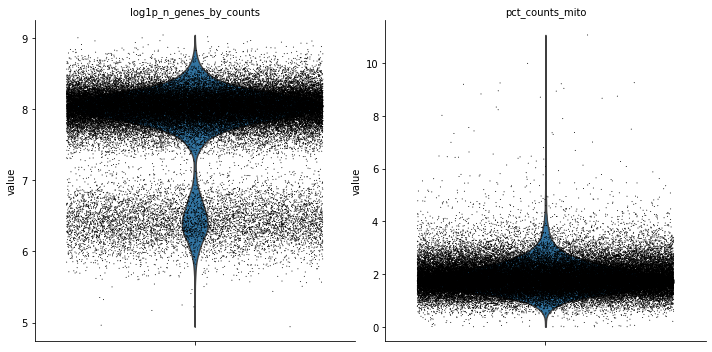

In [33]:
# step2. plotting the qc metrics
sc.pl.violin(adata_FPP, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

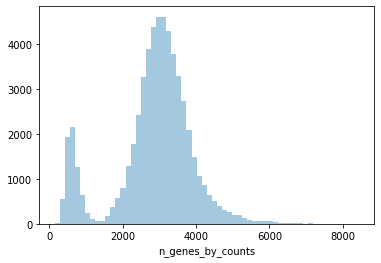

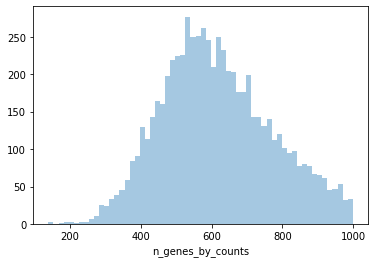

In [34]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_FPP.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

# there seems to be a small population of cells expressing low (1000 gene) count, let's zoom in

p7 = sb.distplot(adata_FPP.obs['n_genes_by_counts'][adata_FPP.obs['n_genes_by_counts']<1000], kde=False, bins=60)
plt.show()

In [35]:
# QC 1 - cell level - remove cells with low gene counts 
# Here, we filter out the cells with low gene counts, threshold set around 1000 - 
# let's filter out 

# for the FPP cells 
print('Number of cells before gene filter: {:d}'.format(adata_FPP.n_obs))
sc.pp.filter_cells(adata_FPP, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata_FPP.n_obs))


Number of cells before gene filter: 58109
Number of cells after gene filter: 51439


In [36]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_FPP.n_obs))
adata_FPP = adata_FPP[adata_FPP.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_FPP.n_obs))




Number of cells before MT filter: 51439
Number of cells after MT filter: 51353


In [37]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the FPP cells
print('Total number of genes: {:d}'.format(adata_FPP.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_FPP, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_FPP.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 20430


In [28]:
adata_FPP.var

,gene_ids-0,gene_ids-1,gene_ids-2,gene_ids-3,gene_ids-4,gene_ids-5,gene_ids-6,gene_ids-7,gene_ids-8,gene_ids-9,...,gene_ids-32,gene_ids-33,mito,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
index,,,,,,,,,,,,,,,,,,,,,
MIR1302-10,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,ENSG00000243485,...,ENSG00000243485,ENSG00000243485,False,55,0.001104,0.001103,99.905350,64.143677,4.176595,51
RP11-34P13.7,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009,...,ENSG00000238009,ENSG00000238009,False,83,0.001205,0.001204,99.857165,70.033684,4.263154,82
AL627309.1,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,ENSG00000237683,...,ENSG00000237683,ENSG00000237683,False,586,0.010276,0.010223,98.991550,597.118835,6.393789,565
AP006222.2,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,ENSG00000228463,...,ENSG00000228463,ENSG00000228463,False,16792,0.319911,0.277564,71.102583,18589.705078,9.830417,16360
RP4-669L17.10,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,ENSG00000237094,...,ENSG00000237094,ENSG00000237094,False,240,0.004139,0.004131,99.586983,240.523209,5.486966,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,ENSG00000220023,...,ENSG00000220023,ENSG00000220023,False,8080,0.146345,0.136579,86.095097,8503.987305,9.048408,7896
AC011841.1,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,ENSG00000212884,...,ENSG00000212884,ENSG00000212884,False,514,0.007584,0.007555,99.115455,440.697571,6.090625,510
AL354822.1,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,ENSG00000215615,...,ENSG00000215615,ENSG00000215615,False,32,0.000636,0.000635,99.944931,36.935844,3.635896,30


In [39]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_FPP_cpm = adata_FPP.copy() # apply this to a copy so we can compare methods
adata_FPP_cpm.raw = adata_FPP_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_FPP_cpm, 
                         counts_per_cell_after=1e6)

In [40]:
# log transformation 
sc.pp.log1p(adata_FPP_cpm)
adata_FPP_cpm

AnnData object with n_obs × n_vars = 51353 × 20430
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_genes', 'n_counts'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-14', 'gene_ids-15', 'gene_ids-16', 'gene_ids-17', 'gene_ids-18', 'gene_ids-19', 'gene_ids-20', 'gene_ids-21', 'gene_ids-22', 'gene_ids-23', 'gene_ids-24', 'gene_ids-25', 'gene_ids-26', 'gene_ids-27', 'gene_ids-28', 'gene_ids-29', 'gene_ids-30', 'gene_ids-31', 'gene_ids-32', 'gene_ids-33', 'mito', 'n_cells_by_counts',

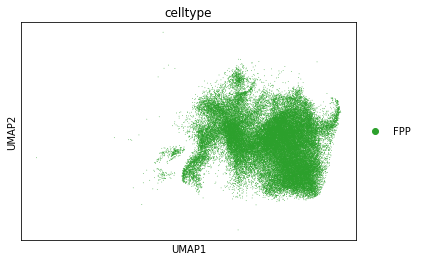

In [31]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_FPP_cpm, color='celltype')

In [41]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_FPP_cpm.var_names)
for k, indices in adata_FPP.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_FPP_cpm.X[indices].mean(axis=0))
df = means

In [43]:
df.to_csv("FPP_D30.csv")

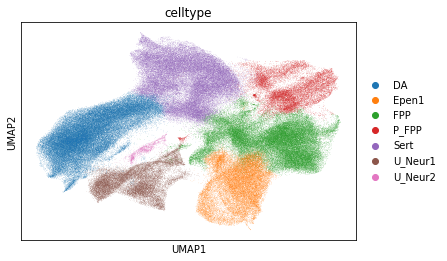

In [35]:
# now let's do the same for the other cell type - PFPP
# since this data has been already clustered and annotated- let's plot the umap plot 
plotting_fcn = sc.pl.umap
plotting_fcn(adata, color='celltype')

In [44]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['P_FPP']
adata_PFPP = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_PFPP.obs.head()

,sample_index,sample_id,donor_id,cluster_id,celltype,time_point,pool_id,treatment
index,,,,,,,,
AAACGGGGTAGTAGTA-1-0,0,5245STDY7387187,HPSI0115i-paim_1,5,P_FPP,D30,pool1,NONE
AAAGCAAAGCGTCTAT-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,5,P_FPP,D30,pool1,NONE
AAAGCAACATGCCTTC-1-0,0,5245STDY7387187,HPSI1113i-podx_1,5,P_FPP,D30,pool1,NONE
AAAGCAATCGATCCCT-1-0,0,5245STDY7387187,HPSI0714i-iudw_1,5,P_FPP,D30,pool1,NONE
AAAGTAGCACGAGAGT-1-0,0,5245STDY7387187,HPSI0114i-eipl_1,5,P_FPP,D30,pool1,NONE


In [45]:
# step1.calclate qc metrics 
adata_PFPP.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_PFPP, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


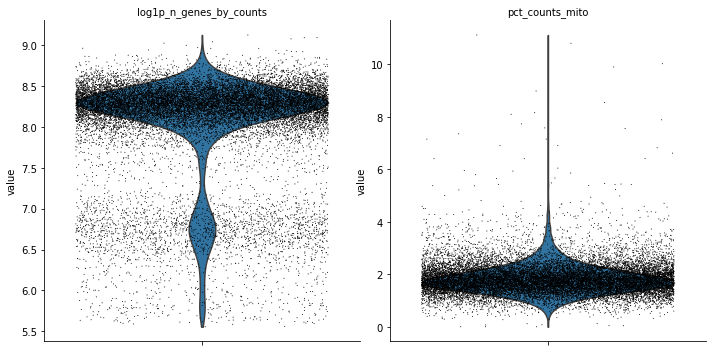

In [46]:
# step2. plotting the qc metrics
sc.pl.violin(adata_PFPP, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

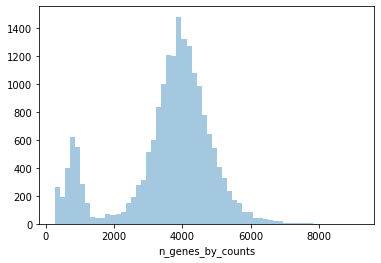

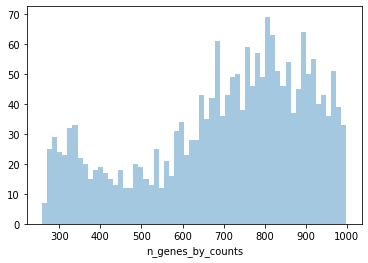

In [47]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_PFPP.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

# there seems to be a small population of cells expressing low (1000 gene) count, let's zoom in

p7 = sb.distplot(adata_PFPP.obs['n_genes_by_counts'][adata_PFPP.obs['n_genes_by_counts']<1000], kde=False, bins=60)
plt.show()

In [48]:
# QC 1 - cell level - remove cells with low gene counts 
# Here, we filter out the cells with low gene counts, threshold set around 1000 - 
# let's filter out 

# for the PFPP cells 
print('Number of cells before gene filter: {:d}'.format(adata_PFPP.n_obs))
sc.pp.filter_cells(adata_PFPP, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata_PFPP.n_obs))

Number of cells before gene filter: 18988
Number of cells after gene filter: 16965


In [49]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_PFPP.n_obs))
adata_PFPP = adata_PFPP[adata_PFPP.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_PFPP.n_obs))

Number of cells before MT filter: 16965
Number of cells after MT filter: 16929


In [50]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the FPP cells
print('Total number of genes: {:d}'.format(adata_PFPP.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_PFPP, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_PFPP.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 18847


In [51]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_PFPP_cpm = adata_PFPP.copy() # apply this to a copy so we can compare methods
adata_PFPP_cpm.raw = adata_PFPP_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_PFPP_cpm, 
                         counts_per_cell_after=1e6)

In [52]:
# log transformation 
sc.pp.log1p(adata_PFPP_cpm)
adata_PFPP_cpm

AnnData object with n_obs × n_vars = 16929 × 18847
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_genes', 'n_counts'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-14', 'gene_ids-15', 'gene_ids-16', 'gene_ids-17', 'gene_ids-18', 'gene_ids-19', 'gene_ids-20', 'gene_ids-21', 'gene_ids-22', 'gene_ids-23', 'gene_ids-24', 'gene_ids-25', 'gene_ids-26', 'gene_ids-27', 'gene_ids-28', 'gene_ids-29', 'gene_ids-30', 'gene_ids-31', 'gene_ids-32', 'gene_ids-33', 'mito', 'n_cells_by_counts',

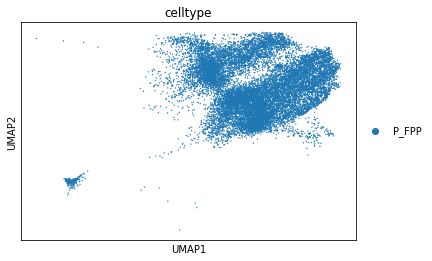

In [18]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_PFPP_cpm, color='celltype')

In [53]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_PFPP_cpm.var_names)
for k, indices in adata_PFPP.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_PFPP_cpm.X[indices].mean(axis=0))
df = means

In [55]:
df.to_csv("PFPP_30.csv")